# Setup packages

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import os
import pandas as pd
import matplotlib.pylab as plt
import numpy as np
import seaborn as sns
# from pymer4.models import Lmer
from natsort import natsorted, ns
import glob
import networkx as nx
from scipy.stats import pearsonr

fpath = 'C:/Users/becha/Desktop/Face_meteor_analysis'

## Loading data for analysis

In [3]:
datalist = natsorted(glob.glob(os.path.join(fpath,'Data', 'preprocessed_data', 'preprocessed_data', "v5","*")))
len(datalist)
print('There are',len(datalist),'groups for v5.')

There are 52 groups for v5.


In [4]:
datall = pd.DataFrame()
for i in range(0,len(datalist)):
    subdata = pd.read_csv(datalist[i])
    datall = datall.append(subdata).reset_index(drop=True)
len(datall)

2080

## Delete round 9 and 10 data within each group

In [5]:
type(datall)
mask1 = datall['round'] != 9
mask2 = datall['round'] != 10
df = datall[mask1 & mask2]
df

,Unnamed: 0,sub_id,origin_sub_No,game_id,game_version,dictator,group_id,round,pgg_share,pgg_receive,pgg_score,dg_ShareTo_p1,dg_ShareTo_p2,dg_ShareTo_p3,dg_ShareTo_p4,dg_RecFrom_p1,dg_RecFrom_p2,dg_RecFrom_p3,dg_RecFrom_p4,dg_score
0,1,KB3m2tJvh6Wr9o36Z,4,kY8RqBzpSv73L2aEz,5,1,52,1,100,230,230,6,6,6,6,6,3,7,5,38
1,2,he9ynyHYduRwyNBCJ,1,kY8RqBzpSv73L2aEz,5,0,52,1,15,50,135,3,21,0,0,6,21,5,5,58
2,3,ucfiinH9NEmNRYn9G,2,kY8RqBzpSv73L2aEz,5,0,52,1,50,90,140,7,5,7,5,6,0,7,5,29
3,4,2SEru9NrTBFQmQbXe,3,kY8RqBzpSv73L2aEz,5,0,52,1,70,100,130,5,5,5,9,6,0,5,9,31
4,5,KB3m2tJvh6Wr9o36Z,4,kY8RqBzpSv73L2aEz,5,1,52,2,70,140,170,6,6,6,6,6,4,8,6,44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2067,28,WEQWgqKeXg2iHwbiq,4,3RnXrkAsmQtMdiA6e,5,0,206,7,100,200,200,6,6,6,6,6,6,6,6,48
2068,29,fjnS9NFtPGN6Z4yM5,1,3RnXrkAsmQtMdiA6e,5,1,206,8,100,200,200,6,6,6,6,6,6,6,6,48
2069,30,HEamyQaiEe2q8itAk,2,3RnXrkAsmQtMdiA6e,5,0,206,8,100,200,200,6,6,6,6,6,6,6,6,48
2070,31,gWDX793Nw5fr64kGc,3,3RnXrkAsmQtMdiA6e,5,0,206,8,100,200,200,6,6,6,6,6,6,6,6,48


# PGG

* Hypothesis: 若該組別在某 round 中出現合作崩解，則那一round中 non-dictator 的 pgg_share 應該較所有組別所有 round 的平均值低。

## The mean & sd of all players' pgg_share

In [6]:
mean_pgg = np.mean(df['pgg_share'])
mean_pgg

73.42127403846153

In [7]:
sd_pgg = np.std(df['pgg_share'])
sd_pgg

28.1427474656489

## for non-dictator

In [8]:
# 寫出每一round的non-dictator的pgg_share。（總共有：8 rounds * 3 non-dictators * 52 groups = 1248）
dat = df[df['dictator'] == 0]
nondic_pgg = dat[["origin_sub_No","game_id","group_id","round","pgg_share"]]
nondic_pgg

,origin_sub_No,game_id,group_id,round,pgg_share
1,1,kY8RqBzpSv73L2aEz,52,1,15
2,2,kY8RqBzpSv73L2aEz,52,1,50
3,3,kY8RqBzpSv73L2aEz,52,1,70
5,1,kY8RqBzpSv73L2aEz,52,2,40
6,2,kY8RqBzpSv73L2aEz,52,2,40
...,...,...,...,...,...
2066,3,3RnXrkAsmQtMdiA6e,206,7,100
2067,4,3RnXrkAsmQtMdiA6e,206,7,100
2069,2,3RnXrkAsmQtMdiA6e,206,8,100
2070,3,3RnXrkAsmQtMdiA6e,206,8,100


## Compare non-dictators' pgg_share with the mean of all players' pgg_share

### std*(-1)

In [9]:
# 低於pgg_share的平均值一個標準差
# nondic_pgg < mean_pgg - sd_pgg*1
comp_1 = mean_pgg - sd_pgg*1
mask_1 = nondic_pgg['pgg_share'] < comp_1
collapse_1 = nondic_pgg[mask_1]
v5_collapsed_id_1 = set(collapse_1['game_id'].values)

collapse_1

,origin_sub_No,game_id,group_id,round,pgg_share
1,1,kY8RqBzpSv73L2aEz,52,1,15
5,1,kY8RqBzpSv73L2aEz,52,2,40
6,2,kY8RqBzpSv73L2aEz,52,2,40
7,3,kY8RqBzpSv73L2aEz,52,2,25
10,2,kY8RqBzpSv73L2aEz,52,3,40
...,...,...,...,...,...
2002,3,SP7DuD4qXj9Ctbw69,205,1,20
2005,1,SP7DuD4qXj9Ctbw69,205,2,40
2006,3,SP7DuD4qXj9Ctbw69,205,2,20
2009,1,SP7DuD4qXj9Ctbw69,205,3,33


c:\users\becha\appdata\local\programs\python\python38-32\lib\site-packages\seaborn\categorical.py:3704: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


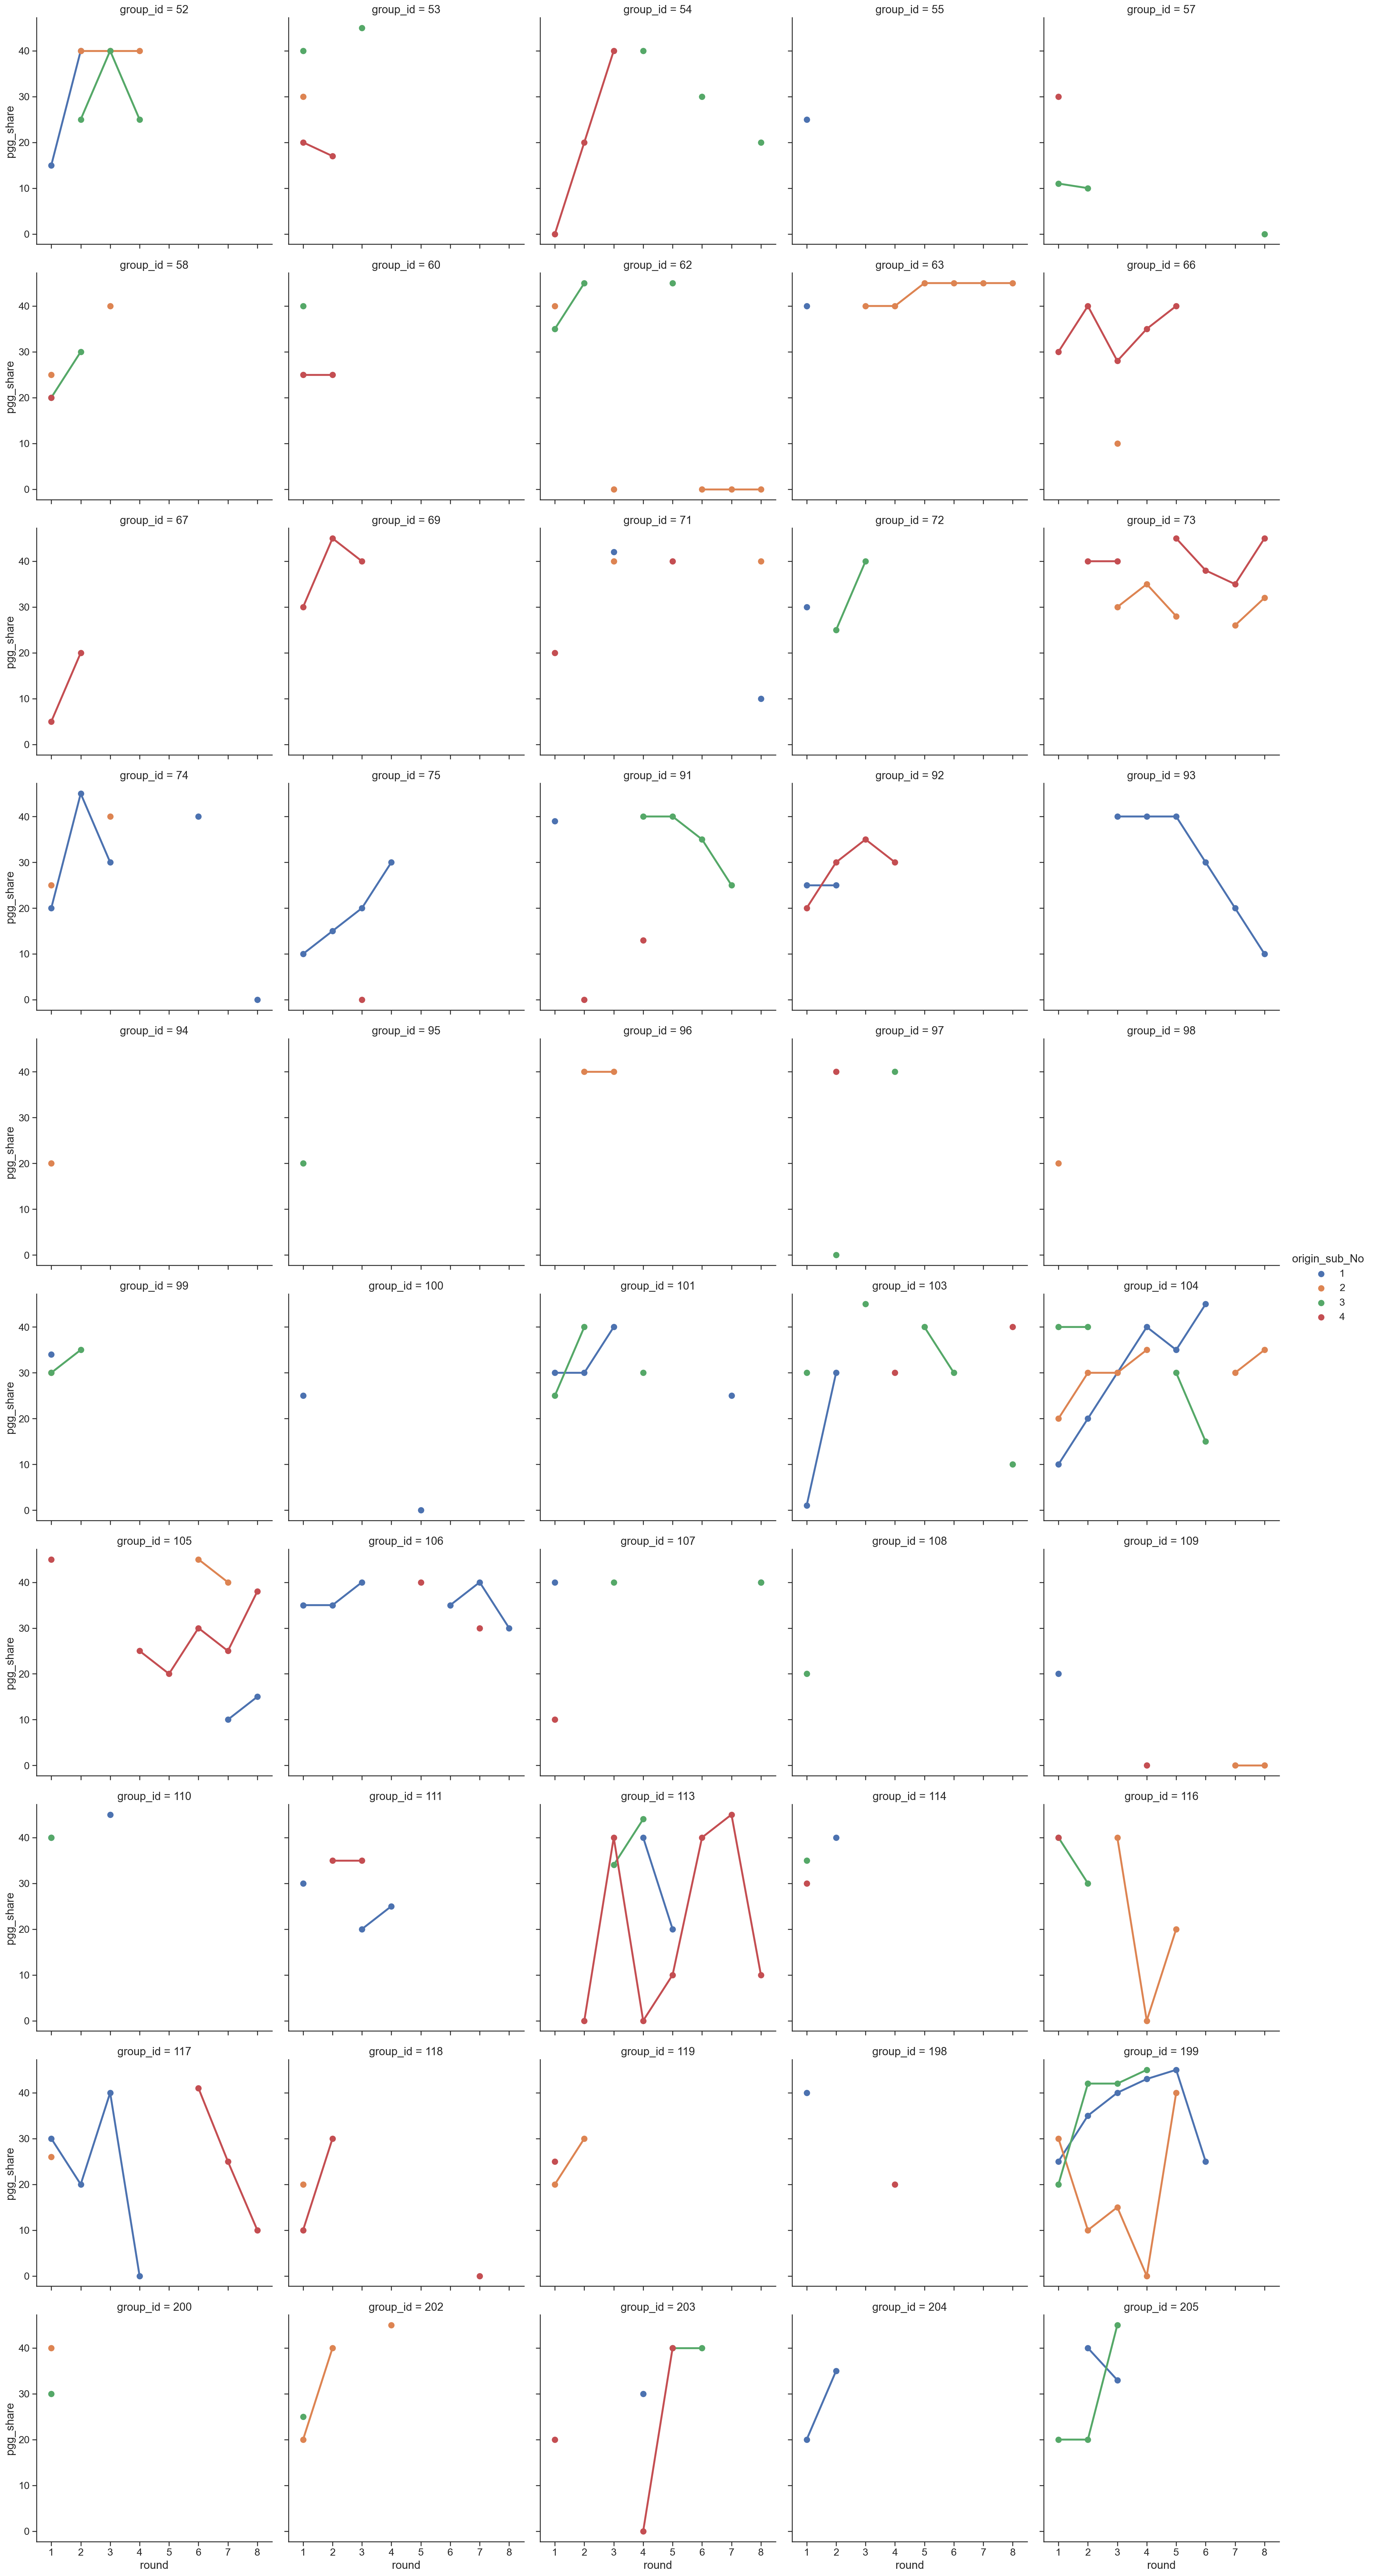

In [10]:
sns.set(style="ticks", font_scale=1.3)
g = sns.factorplot(x="round", y="pgg_share",hue="origin_sub_No",unit='player_id',col_wrap=5, 
                   col='group_id',ci=68, data=collapse_1)

In [11]:
mask1 = nondic_pgg['group_id'] == 52
mask2 = nondic_pgg['group_id'] == 73
mask3 = nondic_pgg['group_id'] == 91
mask4 = nondic_pgg['group_id'] == 93
mask5 = nondic_pgg['group_id'] == 103
mask6 = nondic_pgg['group_id'] == 104
mask7 = nondic_pgg['group_id'] == 105
mask8 = nondic_pgg['group_id'] == 106
mask9 = nondic_pgg['group_id'] == 109
mask10 = nondic_pgg['group_id'] == 113
mask11 = nondic_pgg['group_id'] == 117
mask12 = nondic_pgg['group_id'] == 199
collapse_2 = nondic_pgg[(mask1|mask2|mask3|mask4|mask5|mask6|mask7|mask8|mask9|mask10|mask11|mask12)]

c:\users\becha\appdata\local\programs\python\python38-32\lib\site-packages\seaborn\categorical.py:3704: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


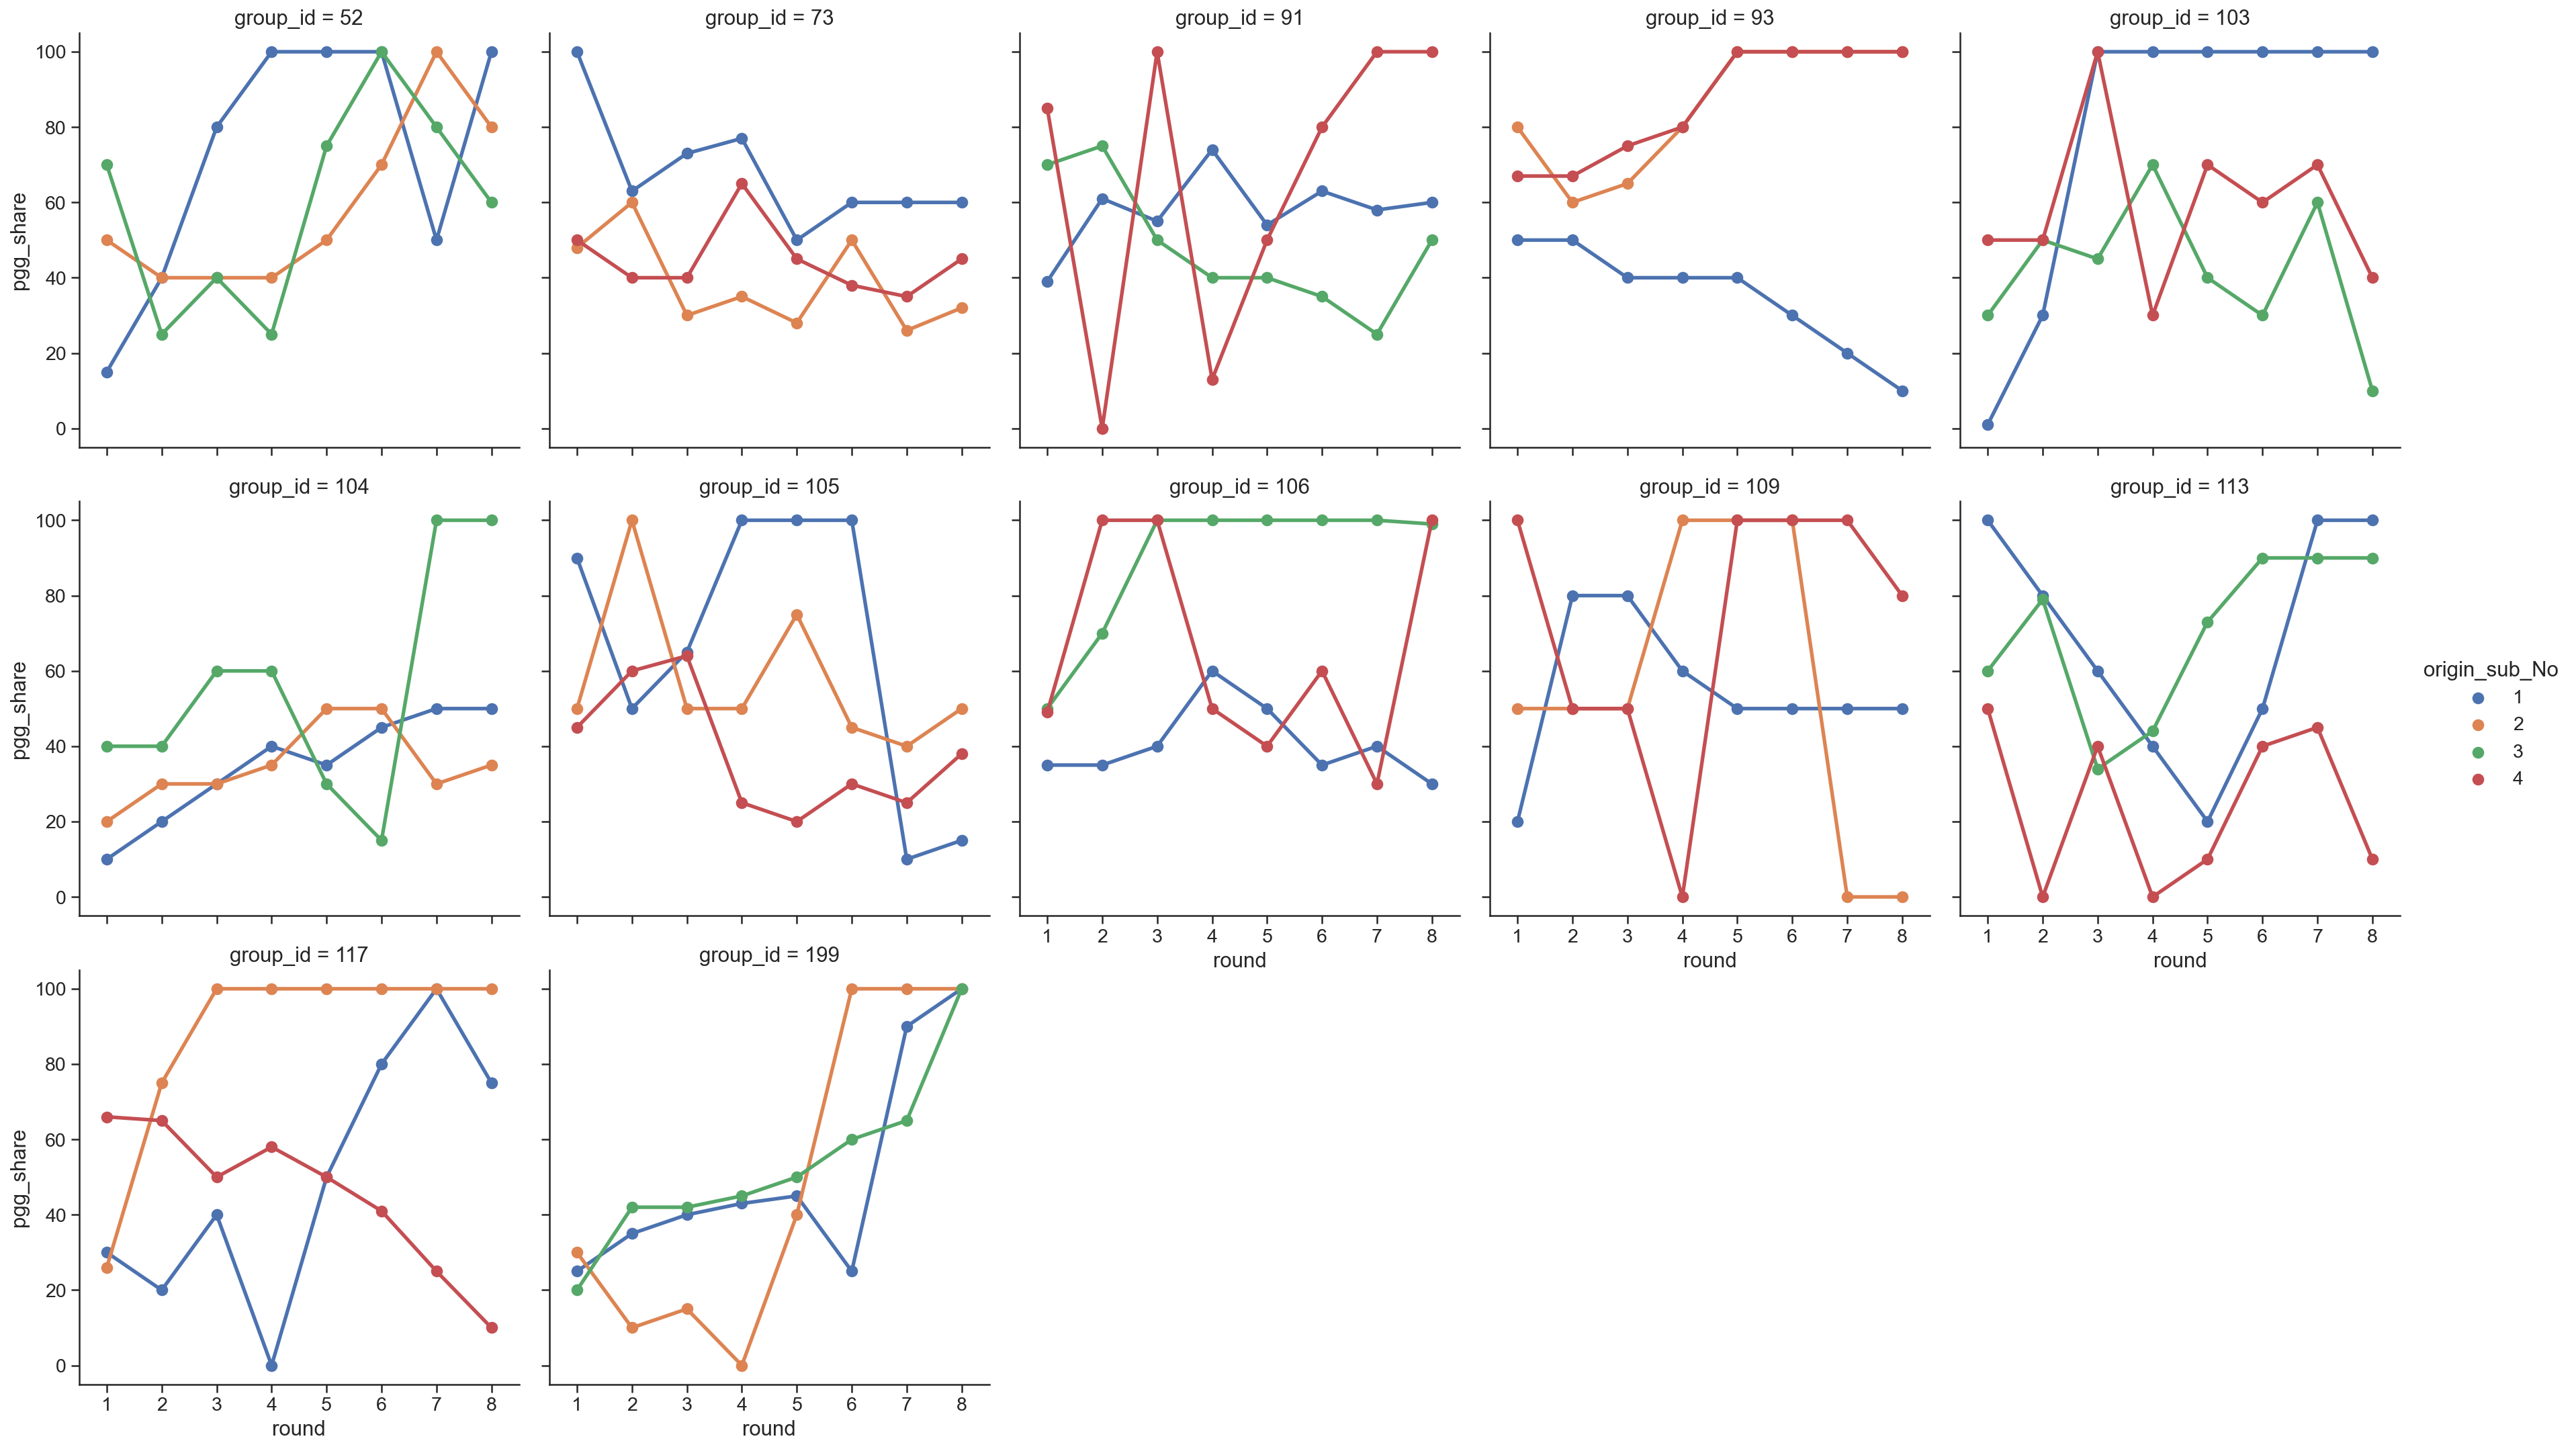

In [12]:
sns.set(style="ticks", font_scale=1.3)
g = sns.factorplot(x="round", y="pgg_share",hue="origin_sub_No",unit='player_id',col_wrap=5, 
                   col='group_id',ci=68, data=collapse_2)

* The corporation-collapsed groups are: 79, 93, 103, 105, 109, 117 

In [13]:
print('The corporation-collapsed ratio:', 6/52)

The corporation-collapsed ratio: 0.11538461538461539


## for dictator

In [14]:
dic = df[df['dictator'] == 1]
mean_Dic = np.mean(dic['pgg_score'])
sd_Dic = np.std(dic['pgg_score'])
# print(len(dic))
print("The mean of all dictator is:", mean_Dic)
print("The sd of all dictator is:", sd_Dic)
print("Two times of sd of all dictator is:", sd_Dic*2)
print("Three times of sd of all dictator is:", sd_Dic*3)
print("Four times of sd of all dictator is:", sd_Dic*4)


The mean of all dictator is: 199.8653846153846
The sd of all dictator is: 55.063304074685725
Two times of sd of all dictator is: 110.12660814937145
Three times of sd of all dictator is: 165.18991222405717
Four times of sd of all dictator is: 220.2532162987429


# DG

* Hypothesis: 若該組別在某 round 中出現合作崩解，則那一round中 non-dictator 的 dg_ShareTo_p1 應該較所有組別所有 round 的平均值低。

## The mean & sd of all players' dg_ShareTo_p1

In [15]:
mean_dg = np.mean(df['dg_ShareTo_p1'])
mean_dg

6.036658653846154

In [16]:
sd_dg = np.std(df['dg_ShareTo_p1'])
sd_dg

2.364699807916372

##  for non-dictator

In [17]:
# 寫出每一round的non-dictator的dg_ShareTo_p1。（總共有：8 rounds * 3 non-dictators * 50 groups = 1200）
nondic_dg = dat[["origin_sub_No","game_id","group_id","round","dg_ShareTo_p1"]]
nondic_dg

,origin_sub_No,game_id,group_id,round,dg_ShareTo_p1
1,1,kY8RqBzpSv73L2aEz,52,1,3
2,2,kY8RqBzpSv73L2aEz,52,1,7
3,3,kY8RqBzpSv73L2aEz,52,1,5
5,1,kY8RqBzpSv73L2aEz,52,2,4
6,2,kY8RqBzpSv73L2aEz,52,2,8
...,...,...,...,...,...
2066,3,3RnXrkAsmQtMdiA6e,206,7,6
2067,4,3RnXrkAsmQtMdiA6e,206,7,6
2069,2,3RnXrkAsmQtMdiA6e,206,8,6
2070,3,3RnXrkAsmQtMdiA6e,206,8,6


## Compare non-dictators' dg_ShareTo_p1 with the mean of all players' dg_ShareTo_p1

### std*(-1)

In [18]:
# 低於dg_ShareTo_p1的平均值一個標準差
# nondic_dg < mean_dg - sd_dg*1
comp_2 = mean_dg - sd_dg*1
mask_2 = nondic_dg['dg_ShareTo_p1'] < comp_2
collapse_3 = nondic_dg[mask_2]
v4_collapsed_id_2 = set(collapse_3['game_id'].values)

collapse_3

,origin_sub_No,game_id,group_id,round,dg_ShareTo_p1
1,1,kY8RqBzpSv73L2aEz,52,1,3
11,3,kY8RqBzpSv73L2aEz,52,3,3
15,3,kY8RqBzpSv73L2aEz,52,4,3
17,1,kY8RqBzpSv73L2aEz,52,5,2
21,1,kY8RqBzpSv73L2aEz,52,6,2
...,...,...,...,...,...
1859,3,sAR7iqP7zu4jnzvym,200,5,0
1930,3,FWoMf7AzAwvm6BEgg,203,3,3
1934,3,FWoMf7AzAwvm6BEgg,203,4,2
1935,4,FWoMf7AzAwvm6BEgg,203,4,0


c:\users\becha\appdata\local\programs\python\python38-32\lib\site-packages\seaborn\categorical.py:3704: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


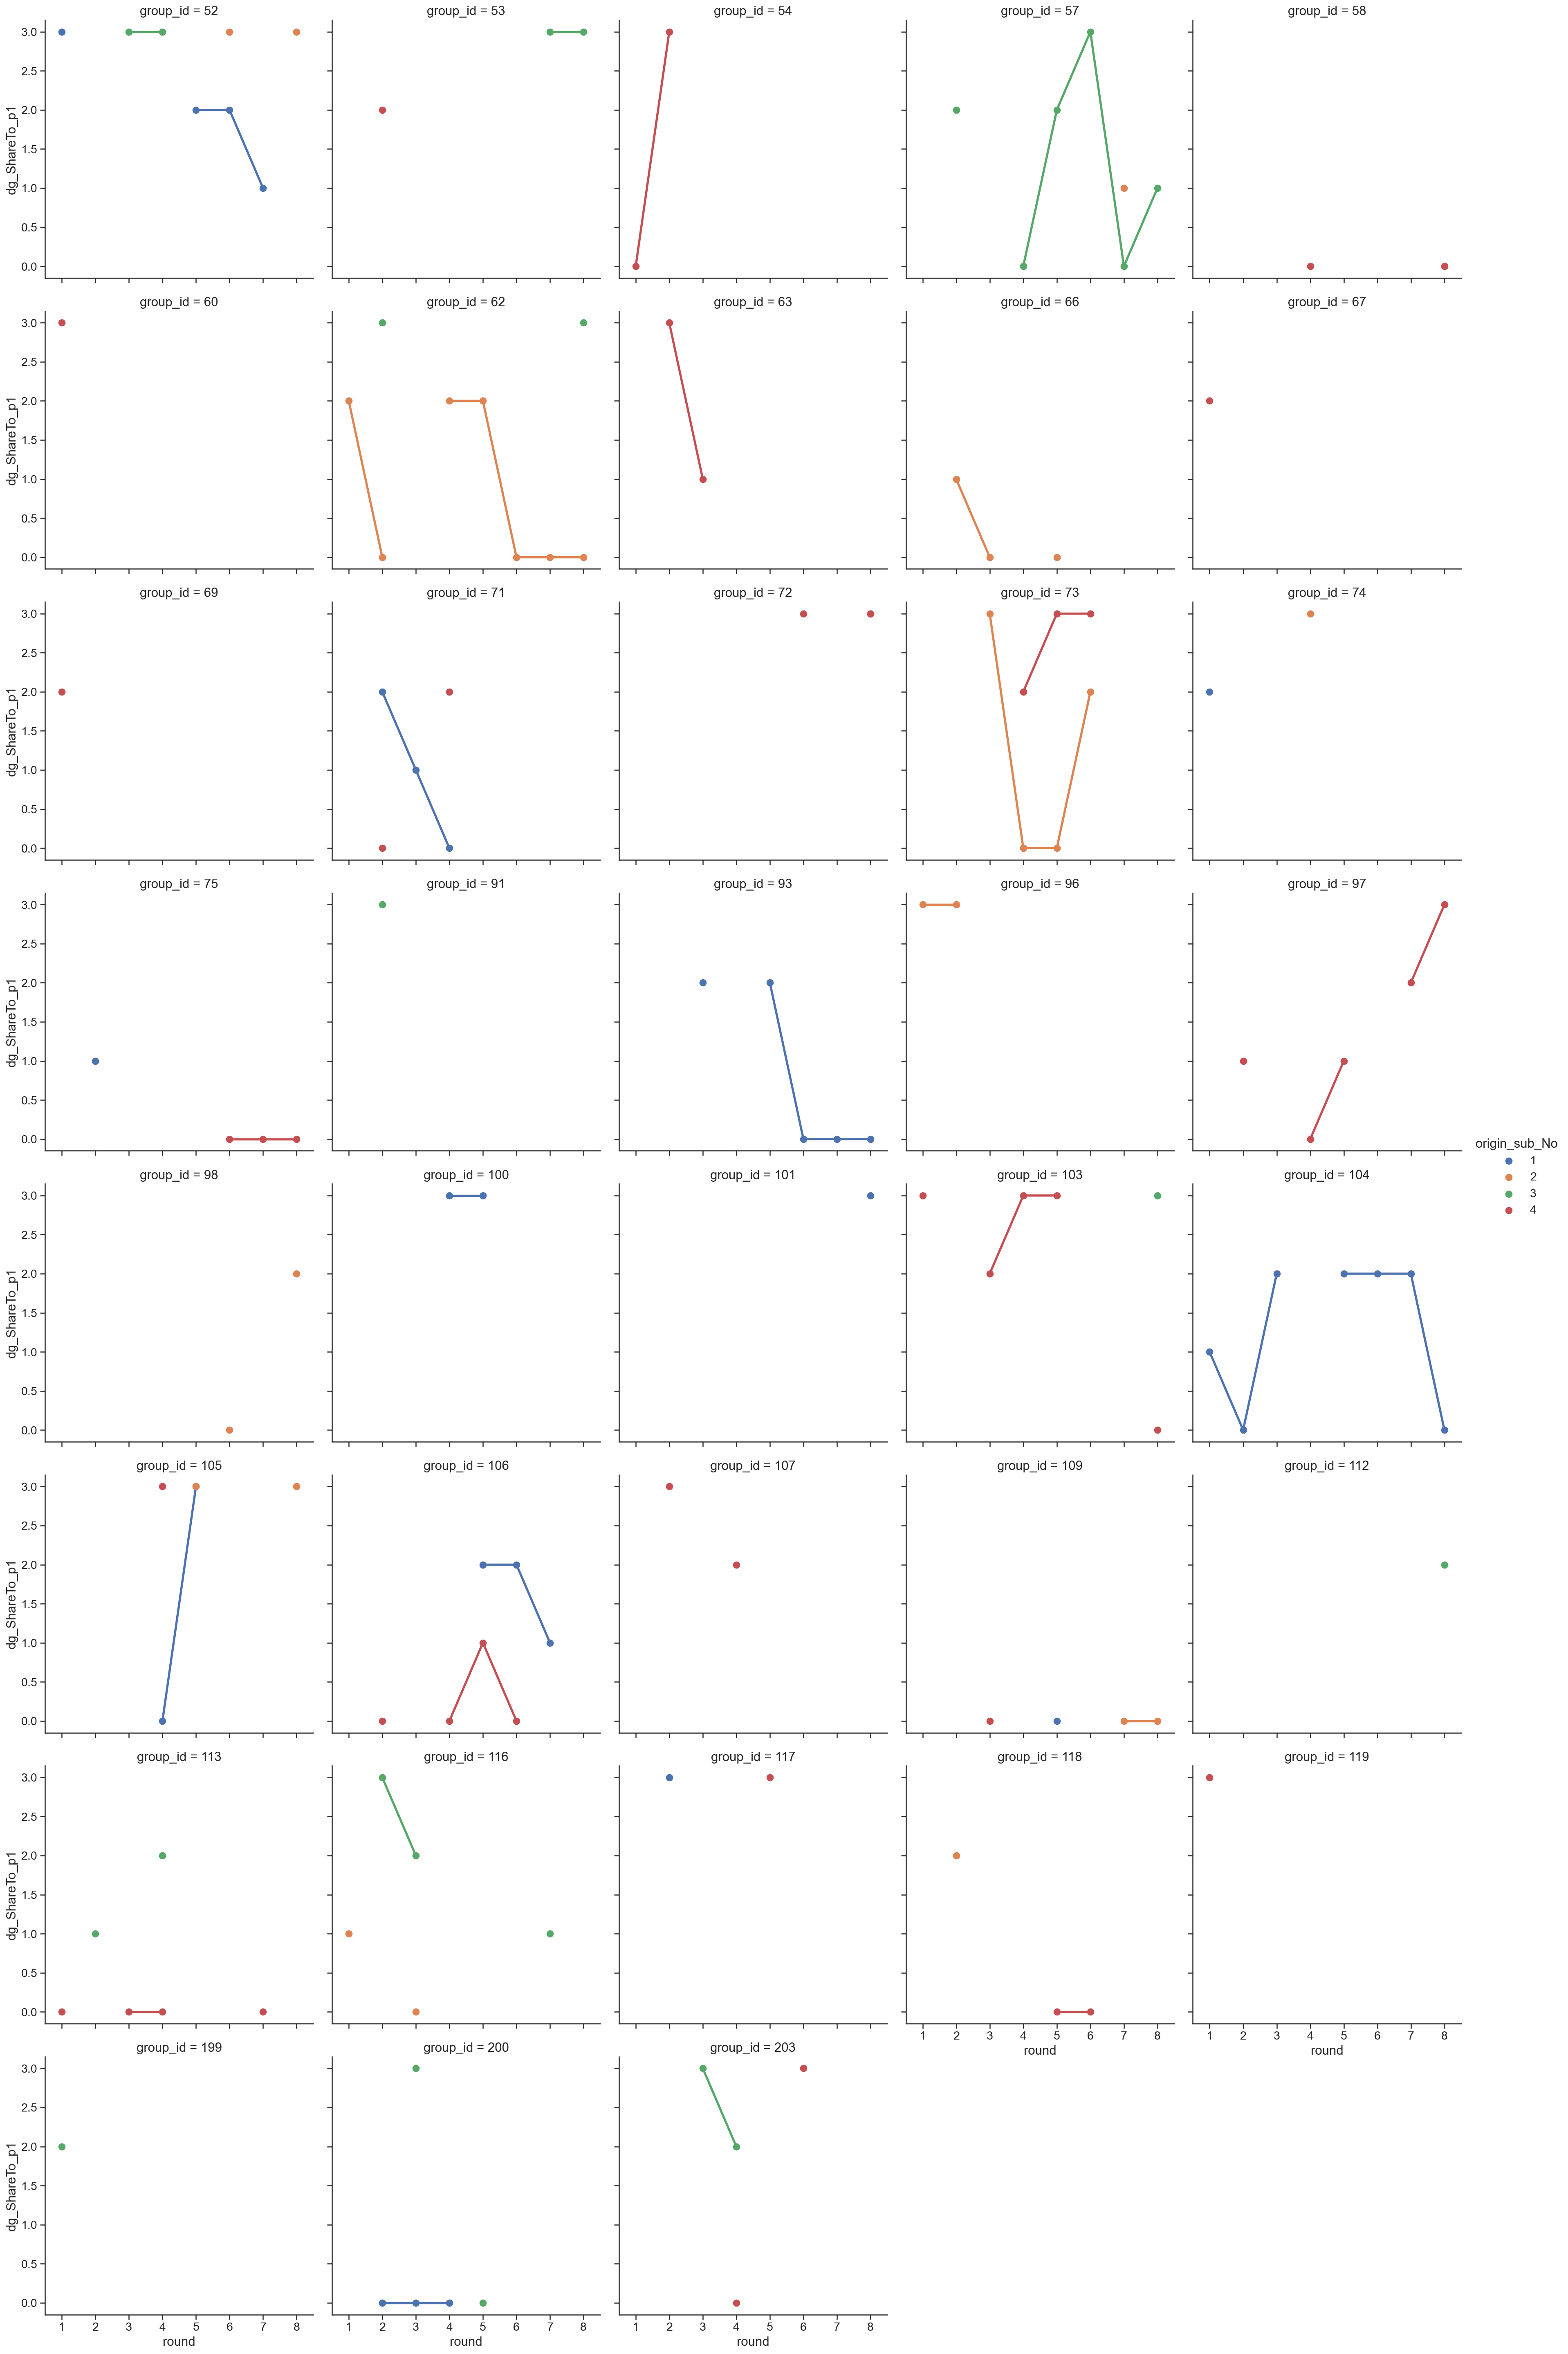

In [19]:
sns.set(style="ticks", font_scale=1.3)
g = sns.factorplot(x="round", y="dg_ShareTo_p1",hue="origin_sub_No",unit='player_id',col_wrap=5, 
                   col='group_id',ci=68, data=collapse_3)